```
# The first time you're running this, install the required packages using the code below
install.packages(c("quanteda", "igraph", "topicmodels"))
# On you own computer, also install tidyverse if needed (on colab it is installed by default)
install.packages("tidyverse")
```

In [1]:
library(tidyverse)
tweets = read_csv("http://cssbook.net/d/covid.csv")
head(tweets)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Parsed with column specification:
cols(
  status_id = col_double(),
  created_at = col_datetime(format = ""),
  screen_name = col_character(),
  lang = col_character(),
  location = col_character(),
  text = col_character(),
  retweet_count = col_double(),
  reply_to_screen_name = col_character()
)



status_id,created_at,screen_name,lang,location,text,retweet_count,reply_to_screen_name
<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1.309536e+18,2020-09-25 16:50:33,ghulamabbasshah,en,"Lahore, Pakistan",Secularism of #Gandhi and #Nehru in #India has been replaced by #RSS #Hindutva . #Muslims falsely blame &amp; victimized for spreading #covid #RSS is an organisation that promotes #Islamophobia India is the only country that witnessed state sponsored Islamophobia. says #ImranKhan https://t.co/HZZEgvBzyW,1203,NA
1.309626e+18,2020-09-25 22:49:07,GeoRebekah,en,"Florida, USA","On the day @GovRonDeSantis rejects the experts and all reason by forcing Florida into Phase III, a 12 year old girl from Atlantic Beach lost her battle with #COVID and died. She was in the sixth grade. Just started school back to at Mayport in Duval. #ThisIsThePrice",1146,NA
1.309578e+18,2020-09-25 19:39:16,AlexBerenson,en,New York,"Updated @cgcgov figures: 66 children under 15 have died from/with #Covid since February. 16,761 have died of other causes. Fewer than 1 in 250 child deaths are related to #Covid in any way. https://t.co/lGT3osyDOg",988,NA
1.309558e+18,2020-09-25 18:18:22,AlexBerenson,en,New York,No mo ro in Flo: @govrondesantis proves again he gets the science and is the best big-state governor on #Covid by not just lifting all restrictions but stopping cities and counties from enforcing their own nonsense. Say it with me: WAAAAIT TWO WEEKS! https://t.co/E4BMxtdIT8,953,NA
1.309643e+18,2020-09-25 23:57:22,B52Malmet,en,"New York, NY","Dr. Fauci warns the worst public health crisis in our lifetime is not what we are going through now, but what is coming in the fall and winter. Keep your laser focus on staying safe, masking up, preparing for #covid winter. Stay strong. Stay well. Only 1st🦵of a marathon.",946,NA
1.309772e+18,2020-09-26 08:28:51,iingwen,en,Taipei City,It’s great to have a genuine friend like #Nauru! Thank you President Aingimea for speaking up for #Taiwan’s rights at #UN75 &amp; telling the world about what we have to offer when it comes to responding to global issues like #COVID. https://t.co/lLb90TiCKH,436,NA


In [2]:
options(tibble.width=120, width=120)
print(tweets, n=3)

# A tibble: 9,811 x 8
  status_id created_at          screen_name  lang  location   text                        retweet_count reply_to_screen…
      <dbl> <dttm>              <chr>        <chr> <chr>      <chr>                               <dbl> <chr>           
1   1.31e18 2020-09-25 16:50:33 ghulamabbas… en    Lahore, P… "Secularism of #Gandhi and…          1203 NA              
2   1.31e18 2020-09-25 22:49:07 GeoRebekah   en    Florida, … "On the day @GovRonDeSanti…          1146 NA              
3   1.31e18 2020-09-25 19:39:16 AlexBerenson en    New York   "Updated @cgcgov figures: …           988 NA              
# … with 9,808 more rows



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


`summarise()` ungrouping output (override with `.groups` argument)



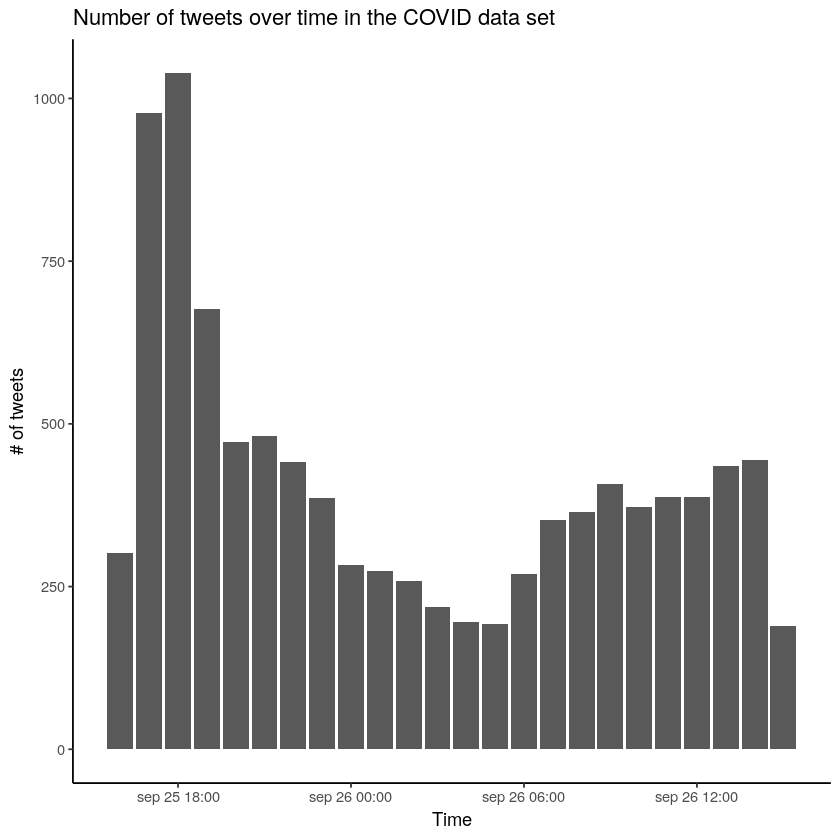

In [3]:
library(lubridate)
tweets_per_hour = tweets %>% mutate(hour=round_date(created_at, "hour")) %>% 
  group_by(hour) %>% summarize(n=n()) 
ggplot(tweets_per_hour, aes(x=hour, y=n)) + 
  geom_col() + theme_classic() + xlab("Time") + ylab("# of tweets") +
  ggtitle("Number of tweets over time in the COVID data set")

Package version: 2.1.0

Parallel computing: 2 of 8 threads used.

See https://quanteda.io for tutorials and examples.


Attaching package: ‘quanteda’


The following object is masked from ‘jupyter:irkernel’:

    View


The following object is masked from ‘package:utils’:

    View




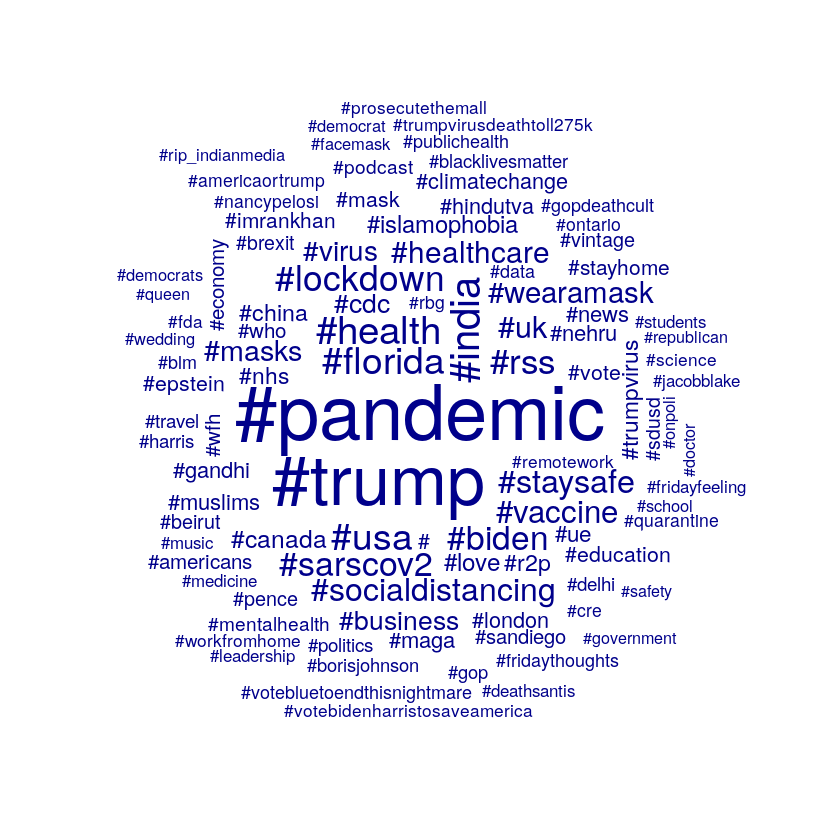

In [4]:
library(quanteda)
dtm_tags = filter(tweets, lang=='en') %>% 
  pull(text) %>% 
  dfm(tolower = T, remove=stopwords('en')) %>% 
  dfm_select(pattern = "#*") %>% 
  dfm_remove(c("#corona*", "#covid*")) 
textplot_wordcloud(dtm_tags, max_words=100)

In [5]:
library(topicmodels)
set.seed(123)
m = convert(dtm_tags, to="topicmodel")  %>% LDA(10, method="Gibbs")
terms(m, 5)

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
#health,#pandemic,#florida,#wfh,#pandemic,#sarscov2,#trump,#india,#trumpvirus,#vaccine
#healthcare,#masks,#staysafe,#sdusd,#canada,#business,#usa,#rss,#trump,#china
#maga,#virus,#socialdistancing,#pandemic,#podcast,#economy,#biden,#islamophobia,#climatechange,#lockdown
#vote,#pence,#lockdown,#workfromhome,#leadership,#wearamask,#uk,#gandhi,#americans,#education
#wearamask,#mask,#love,#remotework,#music,#rip_indianmedia,#r2p,#nehru,#gopdeathcult,#delhi


In [6]:
users = read_csv("http://cssbook.net/d/covid_users.csv")
head(users)

Parsed with column specification:
cols(
  screen_name = col_character(),
  location = col_character(),
  lat = col_double(),
  long = col_double()
)



screen_name,location,lat,long
<chr>,<chr>,<dbl>,<dbl>
ghulamabbasshah,"Lahore, Pakistan",31.56568,74.31418
GeoRebekah,"Florida, USA",27.75677,-81.46398
AlexBerenson,New York,40.71273,-74.00602
B52Malmet,"New York, NY",40.71273,-74.00602
iingwen,Taipei City,25.03752,121.56368
guillonnicola,Un peu partout,NA,NA


Parsed with column specification:
cols(
  screen_name = col_character(),
  location = col_character(),
  lat = col_double(),
  long = col_double()
)

Joining, by = c("screen_name", "location")

Warning message:
“Removed 3371 rows containing missing values (geom_point).”


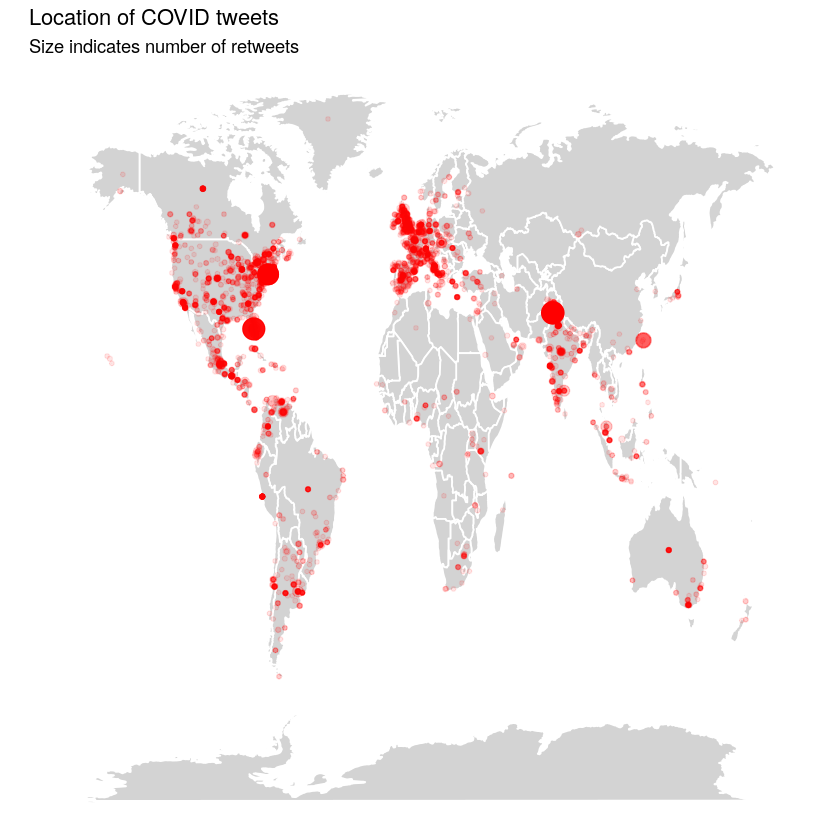

In [7]:
users = read_csv("http://cssbook.net/d/covid_users.csv")
tweets = left_join(tweets, users)
ggplot(mapping=aes(x = long, y = lat)) +
  geom_polygon(aes(group=group), data=map_data('world'), fill="lightgray", colour = "white") +
  geom_point(aes(size=retweet_count, alpha=retweet_count), data=tweets, color='red') + 
  theme_void() + theme(aspect.ratio=1) + guides(alpha=FALSE, size=FALSE) + 
  ggtitle("Location of COVID tweets", "Size indicates number of retweets")

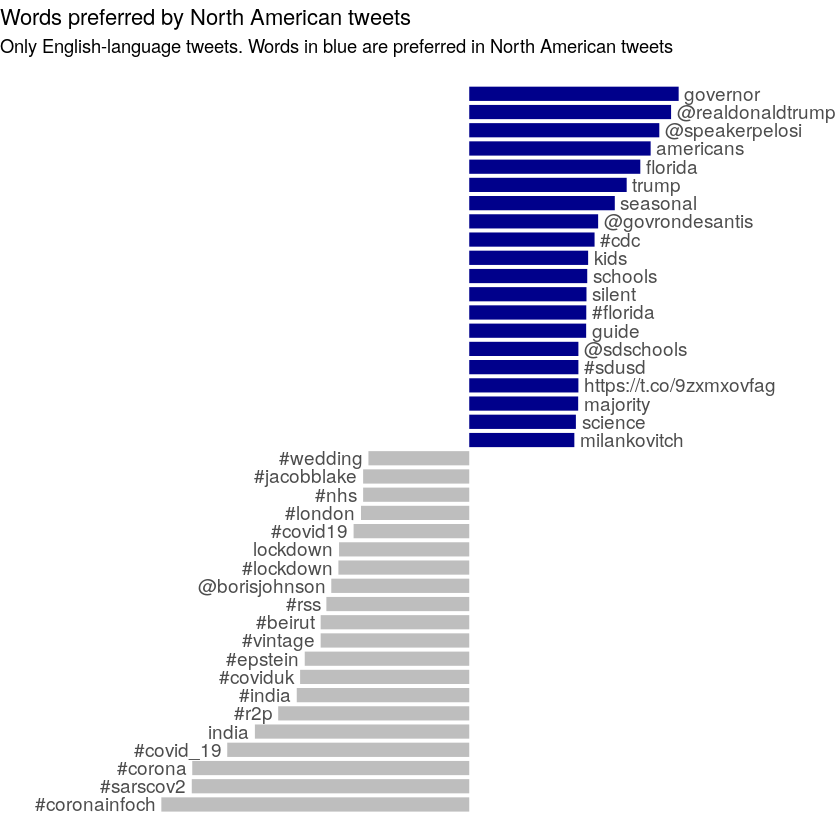

In [8]:
tweets = tweets %>% mutate(northamerica=ifelse(long < -60 & lat > 25, "North America", "Rest"))
dfm = filter(tweets, lang=='en') %>% 
  corpus(docid_field="status_id") %>% 
  dfm(tolower = T, groups="northamerica", remove=stopwords('en'), remove_punct=T) %>% 
  dfm_select(min_nchar=4)
textstat_keyness(dfm, target="North America") %>% 
  textplot_keyness(show_legend=FALSE, margin=0.2) +
  ggtitle("Words preferred by North American tweets", "Only English-language tweets. Words in blue are preferred in North American tweets") + theme_void()


In [9]:
edges = tweets %>% 
  select(from=screen_name, to=reply_to_screen_name) %>% 
  filter(to != "") %>%
  group_by(to, from) %>% 
  summarize(n=n())
head(edges)

`summarise()` regrouping output by 'to' (override with `.groups` argument)



to,from,n
<chr>,<chr>,<int>
_FutureIsUs,_FutureIsUs,1
_JaylaS_,AfronerdRadio,1
_LoveMTB_,ExpatriateNl,1
_nogueiraneto,ideobisium,1
_NotFakeNews_,panich52,1
_vikasupadhyay,SHADABMOHAMMAD7,4



Attaching package: ‘igraph’


The following object is masked from ‘package:quanteda’:

    as.igraph


The following objects are masked from ‘package:lubridate’:

    %--%, union


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




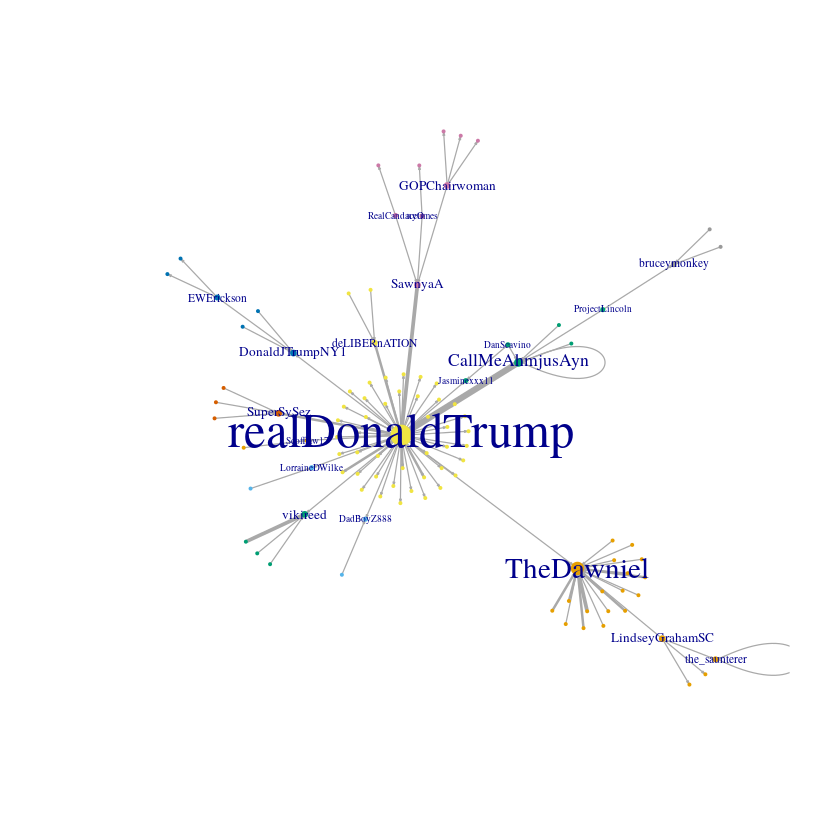

In [10]:
library(igraph)
# create igraph network and select largest component
g = graph_from_data_frame(edges)
components <- decompose.graph(g)
g2 = components[[which.max(sapply(components, gsize))]]
# Color nodes by cluster
clusters = cluster_spinglass(g2)
V(g2)$color = clusters$membership
V(g2)$frame.color = V(g2)$color
# Set node (user) and edge (arrow) size
V(g2)$size = degree(g2)^.5
V(g2)$label.cex = V(g2)$size/3
V(g2)$label = ifelse(degree(g2)<=1, "", V(g2)$name) 
E(g2)$width = E(g2)$n
E(g2)$arrow.size= E(g2)$width/10
plot(g2)

Warning message:
“Removed 3371 rows containing missing values (geom_point).”


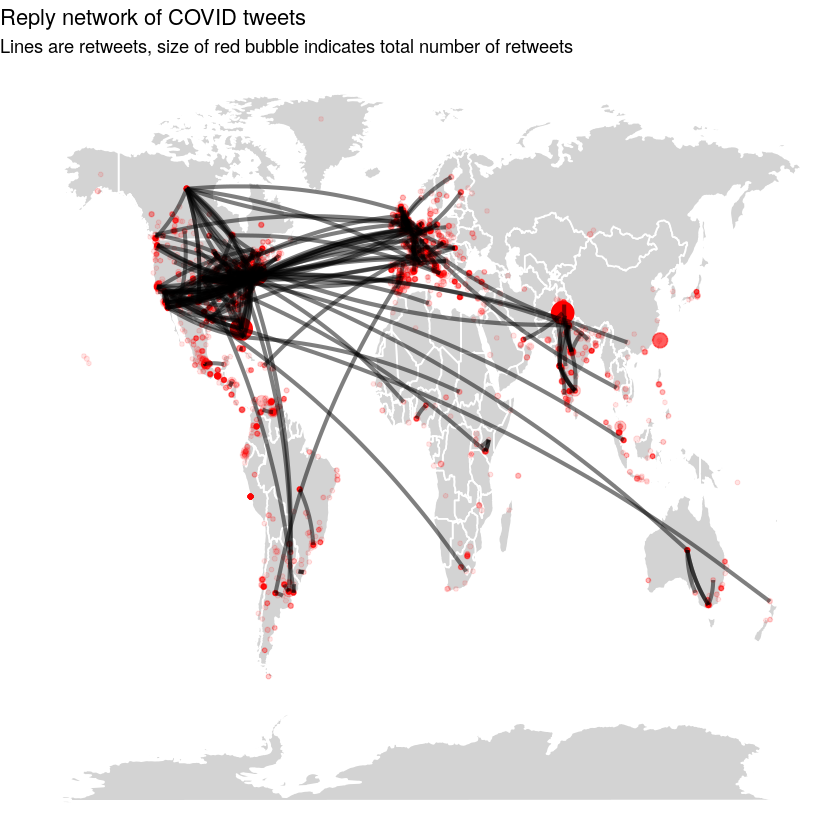

In [11]:
edges2 = edges %>% 
  inner_join(users, by=c("from"="screen_name")) %>% 
  inner_join(users, by=c("to"="screen_name"), suffix=c("", ".to")) %>% 
  filter(lat != lat.to | long != long.to )
ggplot(mapping=aes(x = long, y = lat)) +
  geom_polygon(aes(group=group), map_data('world'), fill="lightgray", colour = "white") +
  geom_point(aes(size=retweet_count, alpha=retweet_count), data=tweets, color='red') + 
  geom_curve(aes(xend=long.to, yend=lat.to, size=n), edges2, curvature=.1, alpha=.5) +
  theme_void() + guides(alpha=FALSE, size=FALSE) + 
  ggtitle("Reply network of COVID tweets", "Lines are retweets, size of red bubble indicates total number of retweets")

In [12]:
# Using twitter to get tweets and user info
library(rtweet)
lookup_users("vanatteveldt")  %>% select("user_id", "screen_name", "location")
tweets = search_tweets("#covid", n = 100, include_rts = FALSE) 
head(tweets)


Attaching package: ‘rtweet’


The following object is masked from ‘package:purrr’:

    flatten




user_id,screen_name,location
<chr>,<chr>,<chr>
155724548,vanatteveldt,Amsterdam


user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,⋯,statuses_count,favourites_count,account_created_at,verified,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url
<chr>,<chr>,<dttm>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<dttm>,<lgl>,<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>
323560573,1315544667631607808,2020-10-12 06:47:45,giulimastro,Worth reading #epidemiology #covid https://t.co/Cb9WeDDO4a,Twitter for iPhone,34,NA,NA,NA,⋯,185,143,2011-06-25 01:30:00,FALSE,NA,NA,NA,https://pbs.twimg.com/profile_banners/323560573/1588869686,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/952201443011854339/9Vhuv3d4_normal.jpg
1283385187649363969,1315544624770035712,2020-10-12 06:47:34,AOUH_AOUH_AOUH,#bourdindirect Les testés positifs au #COVID sont ils tous malades et nouvellement contaminés ? Combien sont positifs mais ont déjà eu le #COVID il y a plusieurs semaines ?,Twitter for Android,173,NA,NA,NA,⋯,7369,5487,2020-07-15 12:57:54,FALSE,NA,NA,NA,https://pbs.twimg.com/profile_banners/1283385187649363969/1596389768,NA,http://pbs.twimg.com/profile_images/1289978993131900928/XGpnZWjB_normal.jpg
1283385187649363969,1315544128491532289,2020-10-12 06:45:36,AOUH_AOUH_AOUH,#bourdindirect La #DictatureSanitaire du #COVID est #EnMarche #antimasques à l'extérieur !,Twitter for Android,91,NA,NA,NA,⋯,7369,5487,2020-07-15 12:57:54,FALSE,NA,NA,NA,https://pbs.twimg.com/profile_banners/1283385187649363969/1596389768,NA,http://pbs.twimg.com/profile_images/1289978993131900928/XGpnZWjB_normal.jpg
4331994379,1315544609397768192,2020-10-12 06:47:31,HumasSalatiga,@yuliyanto_7 @MasHaris03 @Fakruroji1 @humasjateng @ganjarpranowo @TajYasinMZ #salatiga #covid https://t.co/4yTqnZIBat,Twitter for Android,93,NA,1324172606,yuliyanto_7,⋯,3382,850,2015-11-23 08:13:22,FALSE,https://t.co/YTCSQ3BsQt,http://salatiga.go.id,NA,https://pbs.twimg.com/profile_banners/4331994379/1599120143,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1305660616158265344/n8Aln0n4_normal.jpg
859700702,1315544534588297221,2020-10-12 06:47:13,Rarebird67,"@JayneLinney #DePfeffel ..""Schools are Safe"" . #Starmer ..""No ifs or buts"" . #COVID .."" Hold my Beer """,Twitter Web App,97,1315523179943735296,456582393,JayneLinney,⋯,45472,128229,2012-10-03 13:35:47,FALSE,NA,NA,NA,https://pbs.twimg.com/profile_banners/859700702/1401986123,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/620956583460212736/DcwvLL3n_normal.jpg
1734567211,1315544504599011329,2020-10-12 06:47:06,mattino5,"Buon #lunedì da #Mattino5! Siamo in onda e iniziamo subito la puntata parlando del nuovo #DPCM per la lotta al #covid: occhio a movida, feste in casa e sport di contatto https://t.co/GrwWM6L420",Grabyo,170,NA,NA,NA,⋯,36580,3871,2013-09-06 09:07:50,TRUE,https://t.co/OclwVuxWFZ,https://www.facebook.com/mattino5/,NA,https://pbs.twimg.com/profile_banners/1734567211/1593688136,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/923834753941417984/C9JcCCLJ_normal.jpg


In [13]:
# Getting location data
library(tmaptools)
geocode_OSM(c("Amsterdam", "New York"))

query,lat,lon,lat_min,lat_max,lon_min,lon_max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Amsterdam,52.37276,4.893604,52.27817,52.43106,4.728756,5.079162
New York,40.71273,-74.006015,40.47740,40.91618,-74.259090,-73.700181


In [14]:
reply_users = setdiff(tweets$reply_to_screen_name, tweets$screen_name) %>% na.omit()
reply_users = lookup_users(reply_users) %>% select(screen_name, location) 
# Combine with existing users, filter blank locations and duplicate names, and clean location names
users = tweets %>% select(screen_name, location) %>%
  bind_rows(reply_users) %>% 
  unique() %>%
  filter(location != "") %>% 
  mutate(location = str_replace_all(location, "[^\\p{L} ,/-]+", " "))

# Use Open Street Map API to "geocode" the locations and merge back with users
locations = geocode_OSM(unique(users$location)) %>% 
  select(location=query, lat, long=lon)
users = users %>% left_join(locations)
head(users)

No results found for "Western Canada  East needs us ".

No results found for "Europe, Planet Earth, normally".

